In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
import random

## Problem 1

### Part A

In [2]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts = newsgroups.data  
labels = newsgroups.target  
label_names = newsgroups.target_names

In [20]:
def uniform_sample(min_val, max_val, num_samples):   
        return [min_val + (max_val - min_val) * random.random() for _ in range(num_samples)]

samples_uniform = uniform_sample(0, 1, 1000)

(array([106., 111., 106.,  97.,  93.,  94.,  90.,  91., 101., 111.]),
 array([0.00142237, 0.10122819, 0.201034  , 0.30083981, 0.40064563,
        0.50045144, 0.60025725, 0.70006307, 0.79986888, 0.89967469,
        0.99948051]),
 <BarContainer object of 10 artists>)

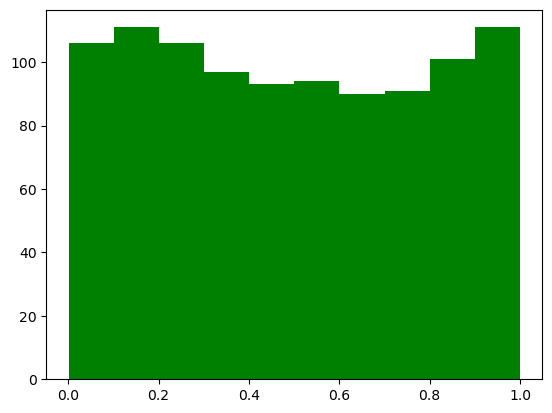

In [21]:
plt.hist(samples_uniform, color='g')

In [23]:
from scipy.integrate import quad 

# inverse transform sampling for Gaussian distribution
def gaussian_pdf(x, mu, sigma):
        return ( 1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x-mu) / sigma) ** 2)

def gaussian_cdf(x, mu,sigma):
        result, _ = quad(lambda t: gaussian_pdf(t,mu,sigma), -np.inf,x) # numerical integration of PDF to CDF
        return result

def inverse_cdf(u, mu, sigma, tol=1e-6, max_iter=100):
        '''
        Approximate inverse CDF(PPF) for N(mu, sigma) using binary search.
        Solv F(x) = u for x, where u is from Uniform(0,1).
        '''
        # bounds that covers ~99.999% of probability
        a = mu - 6*sigma
        b = mu + 6*sigma
        
        for _ in range(max_iter):
                mid =  (a+b) / 2
                cdf_mid = gaussian_cdf(mid, mu, sigma)
                if abs(cdf_mid - u) < tol:
                        return mid
                elif cdf_mid < u:
                        a = mid
                else:
                        b = mid
                
        return (a+b)/2
            
def gaussian_sample(mu, sigma, num_samples):
        U = np.random.uniform(0, 1, num_samples)
        samples = np.array([inverse_cdf(u, mu, sigma) for u in U])
        return samples
# def gaussian_sample(mu, sigma, num_samples):
#         U = np.random.uniform(0, 1, num_samples)
#         Z = norm.ppf(U) # inverse of CDF
#         samples = mu + sigma * Z
#         return samples

samples_norm = gaussian_sample(0,1, 1000)

(array([  9.,  26.,  70., 137., 210., 230., 184.,  89.,  34.,  11.]),
 array([-2.97546387, -2.40355225, -1.83164062, -1.259729  , -0.68781738,
        -0.11590576,  0.45600586,  1.02791748,  1.5998291 ,  2.17174072,
         2.74365234]),
 <BarContainer object of 10 artists>)

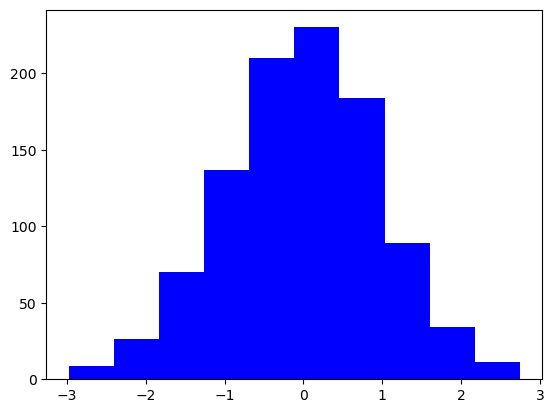

In [24]:
plt.hist(samples_norm, color='b')

In [5]:
def rejection_sampling_gaussian(mu, sigma, sample_size):
    """
    Implement rejection sampling.
    """
    samples = []
    max_density = 1 / (sigma * np.sqrt(2 * np.pi)) # max of the Gaussian PDF
    a = mu - 6*sigma
    b = mu + 6*sigma

    while len(samples) < sample_size:
        x = np.random.uniform(a, b)
        u = np.random.uniform(0, max_density)
        fx = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2) 

        if u < fx:
            samples.append(x)

    return np.array(samples)

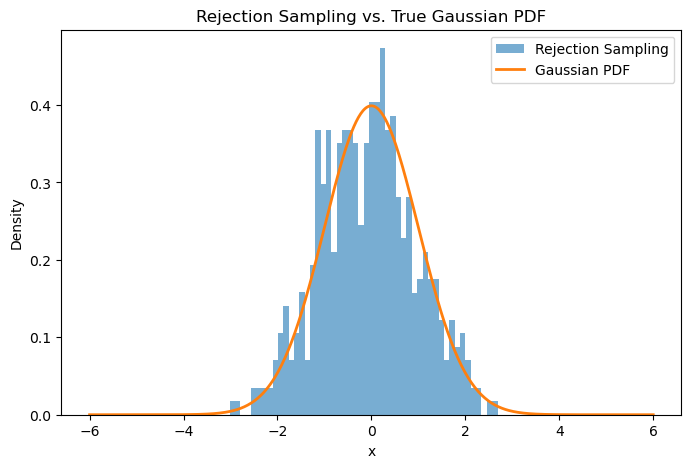

In [7]:
mu, sigma = 0, 1
sample_size = 500

# Generate samples
samples = rejection_sampling_gaussian(mu, sigma, sample_size)

# Visualize
plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, label='Rejection Sampling')
x = np.linspace(mu - 6*sigma, mu + 6*sigma, 500)
pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, pdf, linewidth=2, label='Gaussian PDF')
plt.title('Rejection Sampling vs. True Gaussian PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.show()

### Part B

In [8]:
def gaussian_2d_sample(mu1, sigma1, mu2, sigma2, num_samples):
        samples1 = gaussian_sample(mu1, sigma1, num_samples)
        samples2 = gaussian_sample(mu2, sigma2, num_samples)
        return np.column_stack((samples1, samples2))

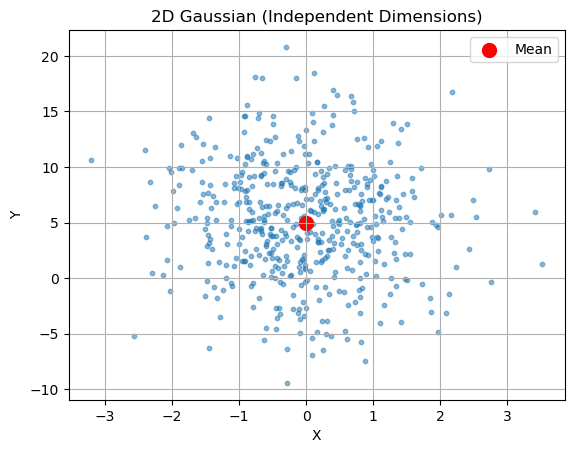

In [10]:
samples_2d = gaussian_2d_sample(mu1=0,mu2=5,sigma1=1,sigma2=5, num_samples=500)

plt.scatter(samples_2d[:, 0], samples_2d[:, 1], alpha=0.5, s=10)
plt.scatter([0], [5], color='red', label='Mean', s=100)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("2D Gaussian (Independent Dimensions)")
plt.legend()
plt.grid(True)
plt.show()

### Part C

In [30]:
from collections import defaultdict, Counter

def stevens_sampling(X, N, groups=10):
        '''
        Steven's method for sampling without replacement.
        :param X:  probability distribution of samples
        :param N: select sampling size
        :param groups: number  of bins
        :return: indices of selected samples
        '''
        X = np.array(X)
        
        quantile_bins = np.quantile(X, np.linspace(0,1,groups+1)) # split X into groups bins
        bin_indices = np.digitize(X,quantile_bins,right=True) # assign group number to index of each sample 
        
        group_dict = defaultdict(list)  # {group: [ sample indices ] }
        for i, b in enumerate(bin_indices):
                group_dict[b].append(i)
            
        groups_keys = sorted(group_dict.keys())
        group_weights = []   
        
        # calculate average weights for each group
        for g in groups_keys:
                indices = group_dict[g]
                weight_sum = np.sum(X[indices])
                group_weights.append(weight_sum)
                
        group_weights = np.array(group_weights)
        group_probs = group_weights / group_weights.sum()
        
        # select groups with replacement
        cum_probs  = np.cumsum(group_probs)
        us = uniform_sample(0, 1, N)
        selected_groups = []
        for u in us:
            # find first bin where cumulative prob exceeds u
            bin_idx = np.searchsorted(cum_probs, u, side='right')
            selected_groups.append(groups_keys[bin_idx]) 
        
        group_counts = Counter(selected_groups)
        
        #Within-bin sampling without replacement via removal
        selected_items = []
        for g, t in group_counts.items():
            items = list(group_dict[g])  # make a mutable copy
            if len(items) < t:
                raise ValueError(f"Not enough items in group {g} to sample {t} unique elements")
            for _ in range(t):
                # draw one uniform index
                u_inner = uniform_sample(0, len(items), 1)[0]
                idx = int(u_inner) if u_inner < len(items) else len(items) - 1
                # remove selected sample and record
                selected_items.append(items.pop(idx))
            
        return selected_items

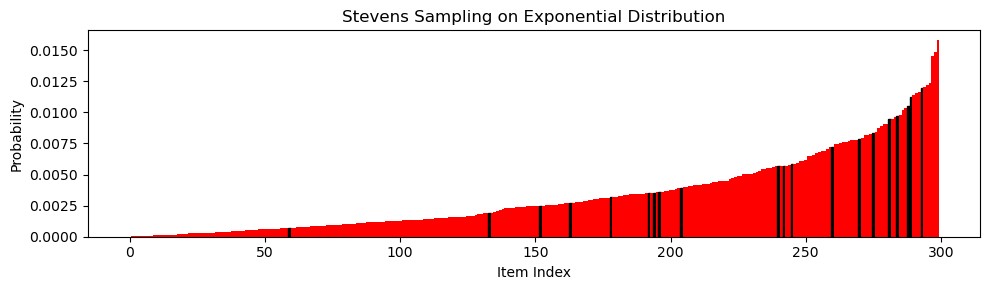

In [31]:
np.random.seed(42)
# selecting 20 samples from 300 items
M = 300 
N = 20
sizes = np.random.exponential(scale=1.0, size=M)
sizes = np.sort(sizes)
probs = sizes / sizes.sum()
selected_stevens = stevens_sampling(sizes, N=N, groups=10)

# Plot result
fig, ax = plt.subplots(figsize=(10, 3))
bars = ax.bar(np.arange(M), probs,width=1.0, color='red')

for idx in selected_stevens:
    bars[idx].set_color('black')

ax.set_title("Stevens Sampling on Exponential Distribution")
ax.set_xlabel("Item Index")
ax.set_ylabel("Probability")
plt.tight_layout()
plt.show()

## Problem 2 Conditional Sampling

In [35]:
def gibbs_sample_2d_gaussian(mu, Sigma, num_samples, burn_in = 100):
        '''
        
        :param mu: array of 2 mu values 
        :param Sigma: covariance matrix, [[s11, s12], [s21, s22]]
        :param num_samples: number of sample
        :param burn_in: disccard first burn_in samples
        :return: 
        '''
        mu = np.array(mu).reshape(2)
        Sigma = np.array(Sigma).reshape(2, 2) # covariance matrix
        mu1,mu2 = mu
        sigma1_sq, sigma2_sq = Sigma[0,0], Sigma[1,1]
        sigma12 = Sigma[0,1]
        
        #conditional variances
        sigma1_given_2_sq = sigma1_sq - sigma12 ** 2 / sigma2_sq
        sigma2_given_1_sq = sigma2_sq - sigma12 ** 2 / sigma1_sq
        
        x2 = mu2 # start at arbitrary choice
        samples = []
        
        for i in range(burn_in + num_samples):
                # Sample x1 given x2
                mu1_given_x2 = mu1 + (sigma12/sigma2_sq) * (x2 - mu2)
                x1 = gaussian_sample(mu=mu1_given_x2, sigma=np.sqrt(sigma1_given_2_sq), num_samples=1)[0]
            
                # Sample x2 given x1
                mu2_given_x1 = mu2 + (sigma12/sigma1_sq) * (x1 - mu1)
                x2 = gaussian_sample(mu2_given_x1, np.sqrt(sigma2_given_1_sq), 1)[0]
            
                if i >= burn_in:
                        samples.append([x1, x2])
                
        return np.array(samples)

In [22]:
mu = [1,2]
Sigma = [[1, 0.5], [0.5, 2]]
num_samples = 500
samples_gibbs = gibbs_sample_2d_gaussian(mu, Sigma, num_samples)
#sample_mean = np.mean(samples_gibbs, axis=0)
#sample_cov = np.cov(samples_gibbs.T)

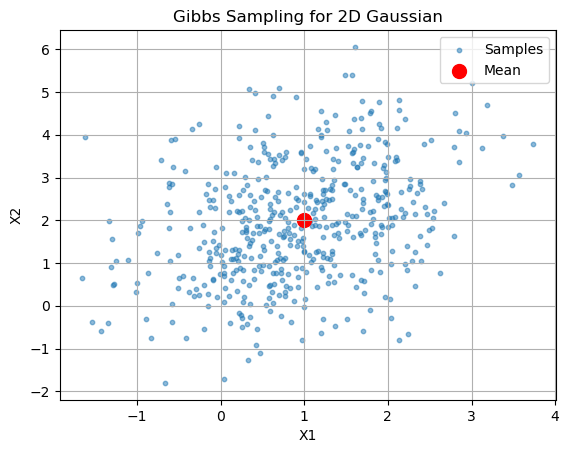

In [24]:
plt.scatter(samples_gibbs[:, 0], samples_gibbs[:, 1], alpha=0.5, s=10, label="Samples")
plt.scatter(mu[0], mu[1], color='red', s=100, label="Mean")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Gibbs Sampling for 2D Gaussian")
plt.legend()
plt.grid(True)
plt.show()

## Problem 3 Implement your own baby-LDA

In [5]:
from nltk.corpus import stopwords, gutenberg
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim import corpora, models
import re

In [3]:
def preprocess_files(files):
    '''
    Turn a list of raw text documents into
    1. A numerical document-term matrix DOCS
    2. A vocabulary mapping words → indices
    3. A list of document lengths
    '''
    stop_words = set(stopwords.words('english'))
    vocab = Counter()
    docs = []
    for file in files:
        tokens = word_tokenize(file.lower())
        tokens = [w for w in tokens if w.isalpha() and len(w) > 2 and w not in stop_words]
        if tokens:
            docs.append(tokens)
            vocab.update(tokens)
    # remove top 1% bottom 1% of words based on frequency
    freq_threshold = np.percentile(list(vocab.values()), [1, 99])
    vocab = {w: i for i, (w, c) in enumerate(vocab.items()) if freq_threshold[0] <= c <= freq_threshold[1]}
    
    N = len(docs)
    DLMAX = max(len(doc) for doc in docs)
    DOCS = np.zeros((N, DLMAX), dtype=int)
    for d in range(N):
        for i, w in enumerate(docs[d][:DLMAX]):
            if w in vocab:
                # the i‑th token of document d is the j-th word in the vocab (+1 so that 0 can represent “no word”)
                DOCS[d, i] = vocab[w] + 1 
    
    return DOCS, vocab, [len(doc) for doc in docs]

def gibbs_lda(DOCS, lengths, K, T, alpha, beta, burn_in):
    '''
    K: number of topics
    alpha: Dirichlet prior over document-topic distribution, smaller alpha means few topics per document
    beta: Dirichlet prior over topic-word distribution, smaller beta means few distinctive words per topic
    
    A[d,0] means topic 1
    B[0,:] means topic 1
    Z[d,i] = 1 means assigned to topic 1, 0 means no topic assigned, so topics numer needs -1 from Z to A and B
    
    Return:
        Z: topic assignment for each word in each document
        A_mean: expected number of times topic k appears in document d
        B_mean: expected number of times word w appears in topic k
    '''
    N, DLMAX = DOCS.shape   
    W = np.max(DOCS)
    alpha_vec = alpha * np.ones(K)
    beta_vec = beta * np.ones(W)
    
    Z = np.zeros((N, DLMAX), dtype=int) 
    A = np.tile(alpha_vec, (N, 1))  # doc-topic count
    B = np.tile(beta_vec, (K, 1))    # topic-word count
    BSUM = np.sum(B, axis=1)     # total word count per topic
    
    A_sum = np.zeros_like(A, dtype=float)
    B_sum = np.zeros_like(B, dtype=float)
    samples_collected = 0

    for t in range(T):                        # number of iterations
        for d in range(N):                  # number of docs
            for i in range(lengths[d]):  # length of d-th doc 
                w = DOCS[d, i]              # count of the i-th word in the d-th doc
                if w == 0:
                    continue
                zi = Z[d, i] # d-th doc, i-th word's topic assignment
                if zi > 0:    # z = 0 means no topic assigned to this word
                    # remove old topic assignment before assigning new topic
                    A[d, zi - 1] -= 1
                    B[zi - 1, w - 1] -= 1
                    BSUM[zi - 1] -= 1
                
                # Sampling new topic
                dst = A[d, :] * (B[:, w - 1] / BSUM)  # P(z=k∣w,d)∝(doc-topic proportion)×(topic-word probability)
                dst = dst / np.sum(dst)
                
                new_zi = np.random.choice(K, p=dst) + 1
                Z[d, i] = new_zi
                
                A[d, new_zi - 1] += 1
                B[new_zi - 1, w - 1] += 1
                BSUM[new_zi - 1] += 1

        # After processing all documents in iteration t:
        if t >= burn_in:
            A_sum += A
            B_sum += B
            samples_collected += 1
        if t == burn_in - 1:
            print(f"Burn-in completed at iteration {t + 1}")
    
    A_mean = A_sum / samples_collected if samples_collected > 0 else A
    B_mean = B_sum / samples_collected if samples_collected > 0 else B
    
    return Z, A_mean, B_mean

def plot_wordclouds(B, vocab, K):
    vocab_inv = {i + 1: w for w, i in vocab.items()}
    for k in range(K):
        word_freq = {vocab_inv.get(w + 1, 'unknown'): B[k, w] for w in range(B.shape[1]) if w + 1 in vocab_inv}
        if word_freq:
            wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
            plt.figure(figsize=(8, 4))
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title(f'Topic {k + 1}')
            plt.show()

In [8]:
with open('Datasets/sonnetsPreprocessed.txt', 'r', encoding='utf-8') as f:
        sonnets = f.readlines()
DOCS, vocab, lengths = preprocess_files(sonnets)

In [11]:
len(sonnets)

154

In [12]:
np.max(DOCS)

3064

In [105]:
N, DLMAX = DOCS.shape

In [106]:
Z, A, B = gibbs_lda(DOCS, lengths, K=6, T=1000, alpha=5, beta=0.1,burn_in=100)

Burn-in completed at iteration 100


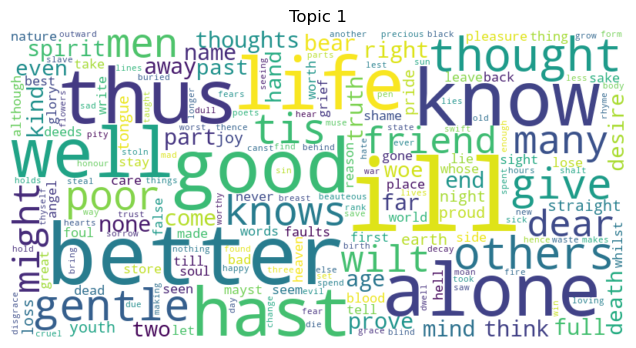

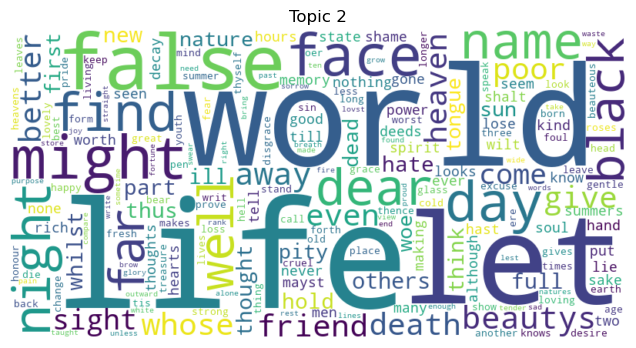

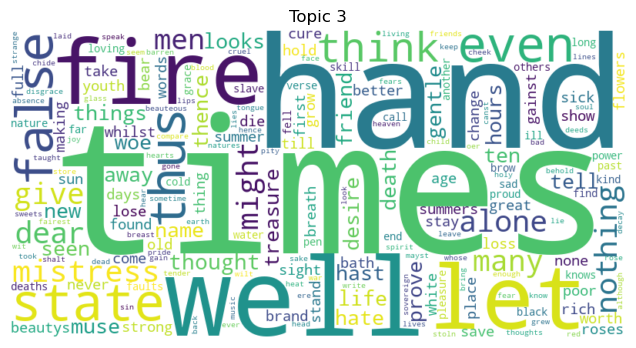

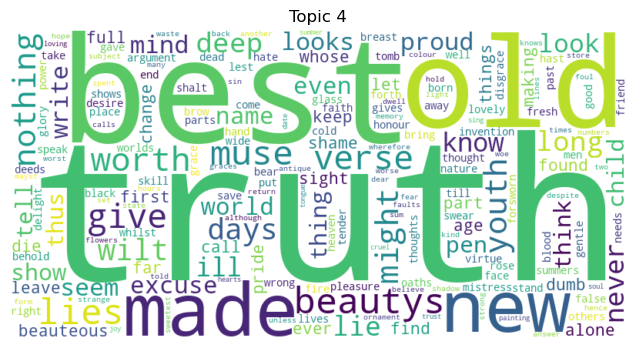

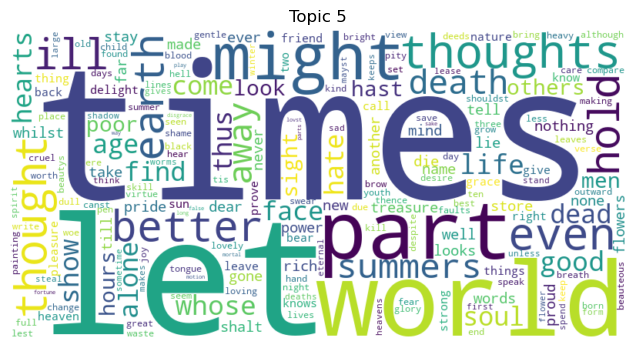

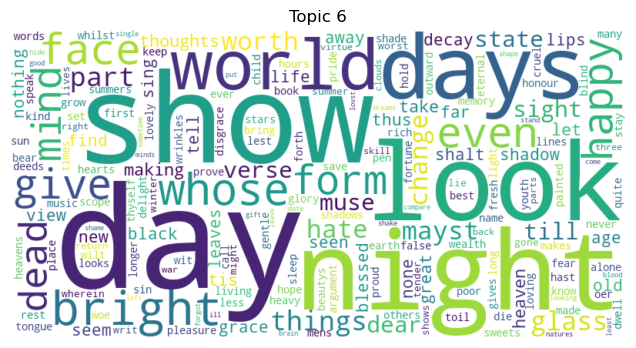

In [107]:
plot_wordclouds(B, vocab, K=6)

In [109]:
DOCS, vocab, lengths = preprocess_files(texts)

In [ ]:
N, DLMAX = DOCS.shape
Z, A, B = gibbs_lda(DOCS, lengths, K=20, T=1000, alpha=2, beta=0.1,burn_in=100)

Burn-in completed at iteration 100


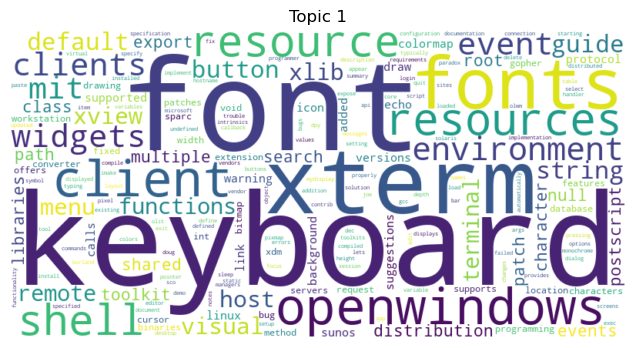

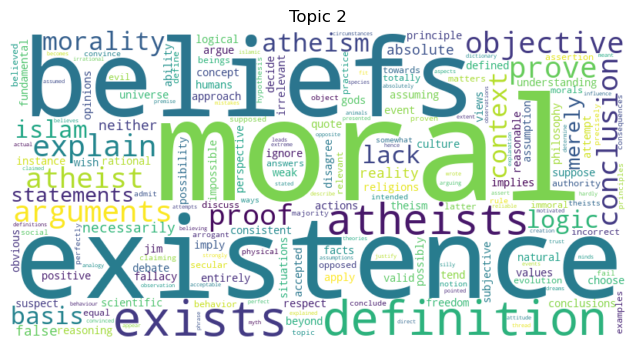

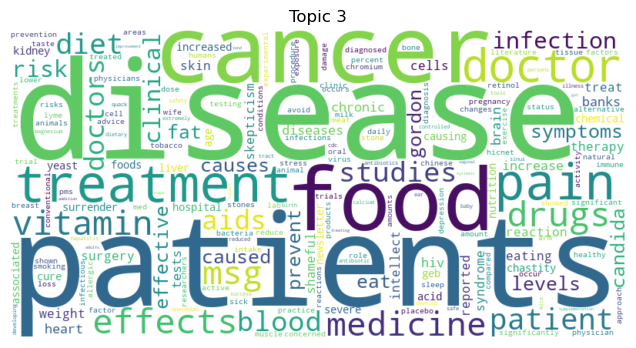

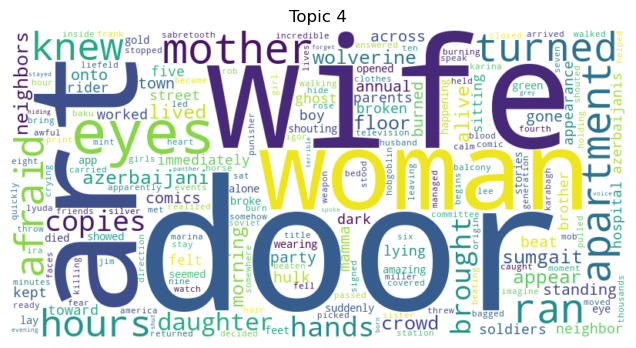

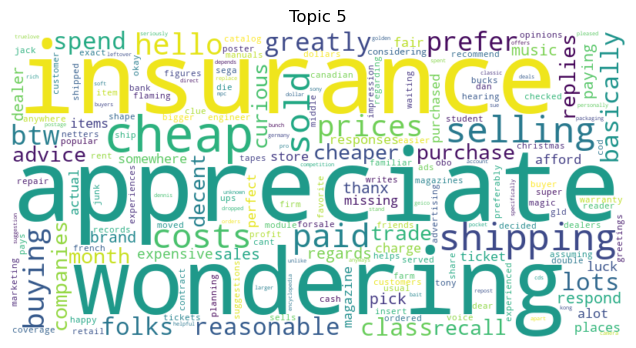

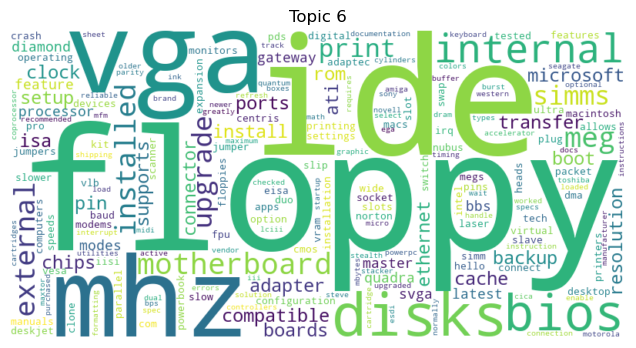

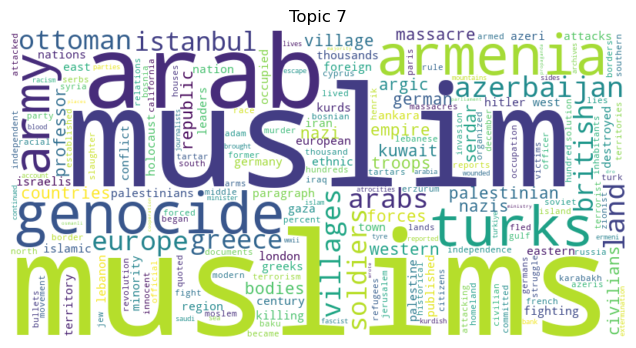

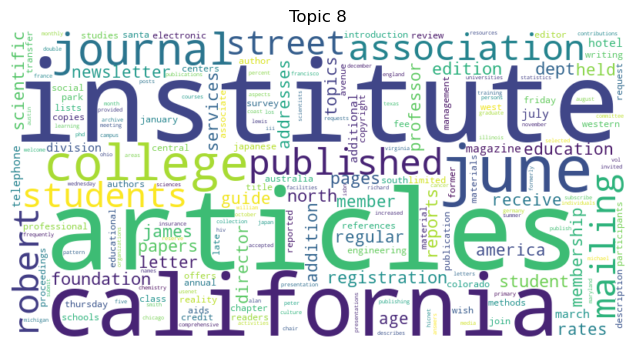

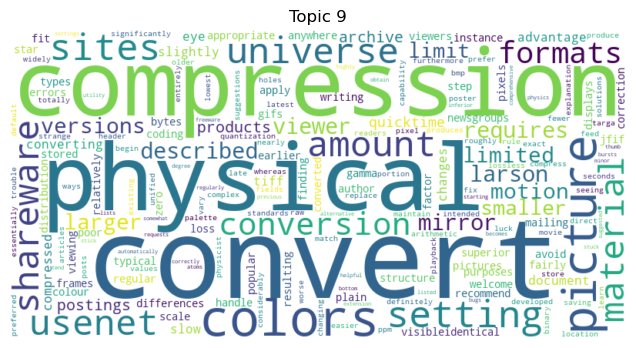

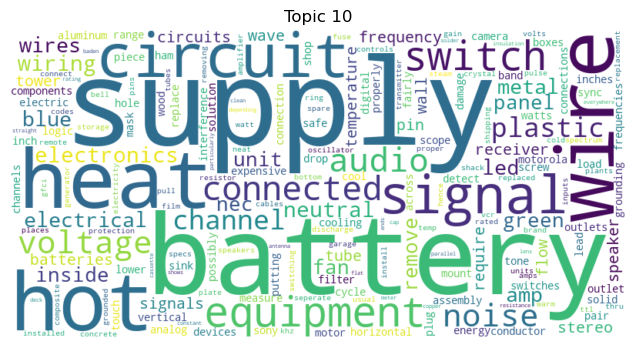

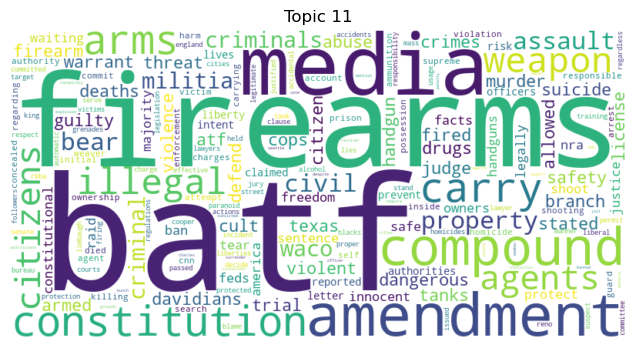

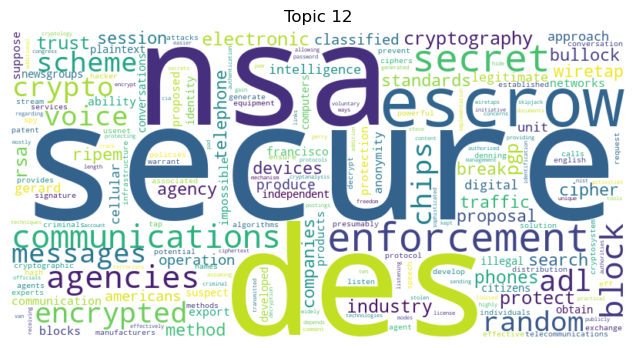

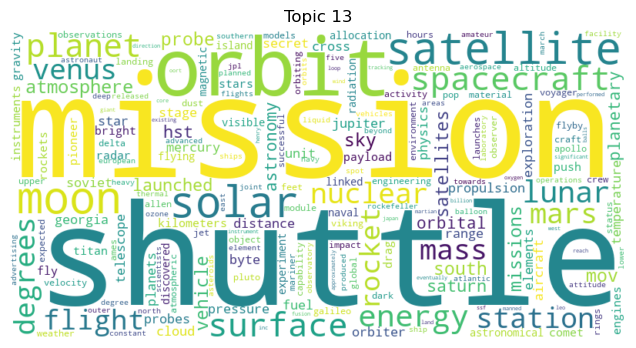

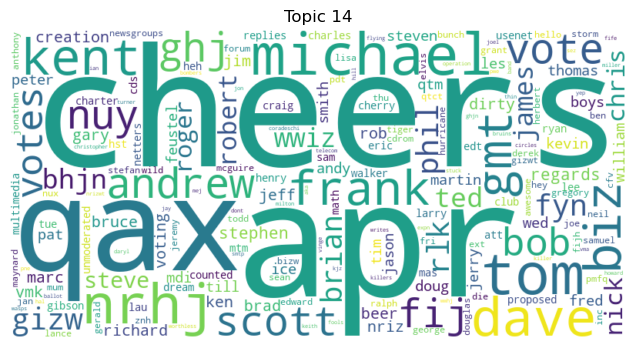

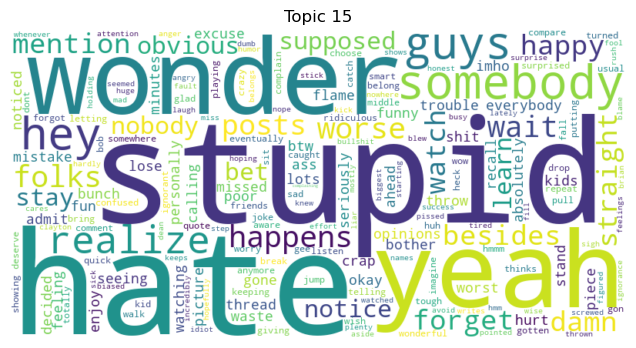

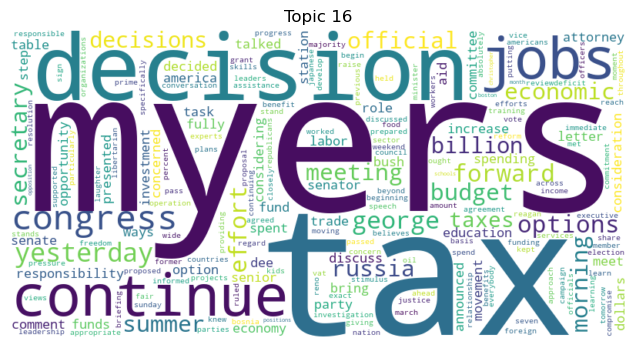

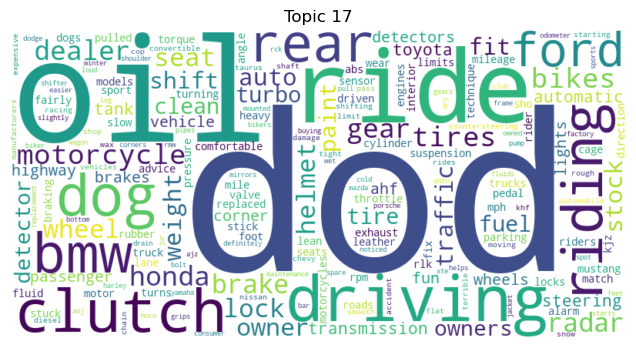

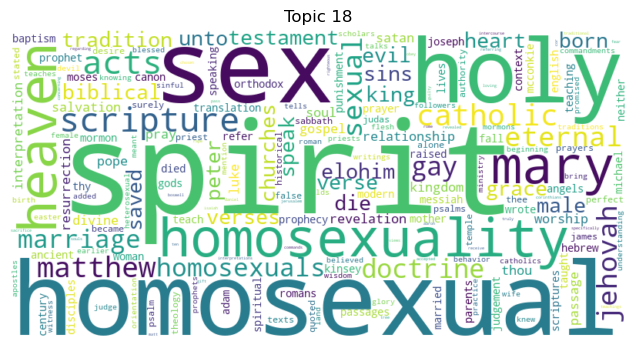

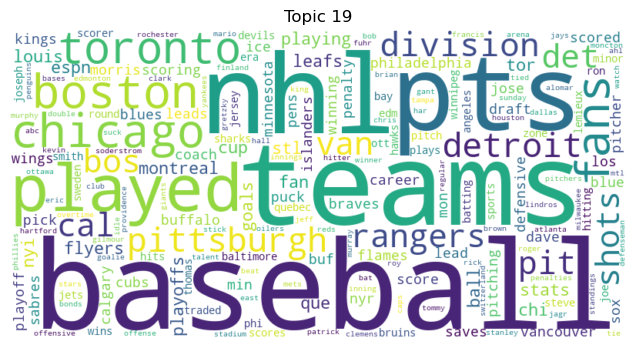

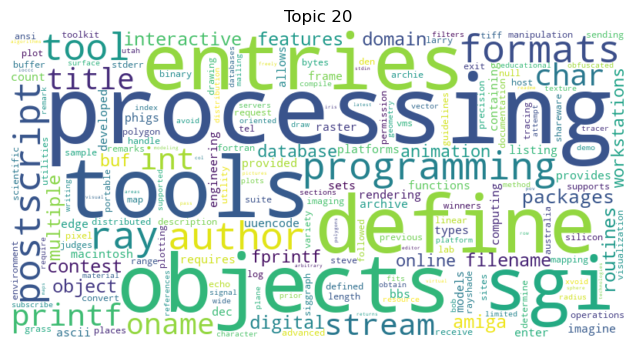

In [ ]:
plot_wordclouds(B, vocab, K=20)